In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
get_ipython().magic('matplotlib inline')

import os
from copy import deepcopy

from sklearn.model_selection import GroupKFold, GroupShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from sklearn.feature_selection import SelectFromModel

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
from sklearn.metrics import roc_curve, precision_recall_curve, average_precision_score

import sklearn
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score

from tqdm import tnrange, tqdm_notebook

from matplotlib import colors as mcolors
import random
from matplotlib.backends.backend_pdf import PdfPages

import re

import winsound

In [2]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
get_ipython().magic('matplotlib inline')

import os
from copy import deepcopy

from sklearn.model_selection import GroupKFold, GroupShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from sklearn.feature_selection import SelectFromModel

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
from sklearn.metrics import roc_curve, precision_recall_curve, average_precision_score

import sklearn
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score

from tqdm import tnrange, tqdm_notebook

from matplotlib import colors as mcolors
import random
from matplotlib.backends.backend_pdf import PdfPages

import re

import winsound


class Magnesium2(object):
    def __init__(self, file_, model = None, fold = "rna-ion-step2/", with_groups = True):
        self.filename = file_.split('.csv')[0]
        if model is not None:
            self.model = model            
        else:
            self.model = RandomForestClassifier(n_estimators=200, n_jobs=-1, criterion='gini')
        self.model_name = str(self.model).split('(')[0]
        self.trained_model = None
        self.data = pd.read_table(fold+file_).dropna()        
        self.data_numpy = np.matrix(self.data)
        self.features = list(self.data.columns)[1:]
        self.groups = self.data_numpy[:,:1]
        self.x = self.data_numpy[:, 1:-1]
        self.xt = None
        self.y = np.array(self.data_numpy[:,-1].flatten().tolist()[0])   
        self.y_pred = None
        self.y_prob = []
        self.indexes = []
        self.with_groups = with_groups
        
        self.important_features = None
        self.train_score = []
        self.test_score= []
        self.test_roc_auc_score = []
        self.gridsearched_model = None
        self.tresholds = []
        self.prec_rec_data = {'precision':[], 'recall':[]}
       
    def choose_features(self, save_to_file = True, plot = True):
        classifier = self.model
        if self.with_groups:
            gss = GroupShuffleSplit(n_splits = 3, test_size = 0.3, random_state = 0)
            splitted = gss.split(self.x, self.y, groups = self.groups)
        else:
            gss = StratifiedShuffleSplit(n_splits = 3, test_size = 0.3, random_state = 0)
            splitted = gss.split(self.x, self.y)
        for train_index, test_index in splitted:        
            x_train = self.x[train_index]
            y_train = self.y[train_index]
            classifier.fit(x_train, y_train)
        model = SelectFromModel(classifier, prefit = True)
        self.xt = model.transform(self.x)
        print("Feature reduction: %d -> %d" % (self.x.shape[1], self.xt.shape[1]))
        
        importances = classifier.feature_importances_
        indices = np.argsort(importances)[::-1]
        
        if save_to_file:
            file = open('Ranked features, %s.txt' % self.filename, 'w')
            for f in range(self.x.shape[1]):
                file.write("%d. %s (%f)\n" % (f + 1, self.features[indices[f]], importances[indices[f]]))
            file.close()
        
        if plot:
            std = np.std([tree.feature_importances_ for tree in classifier.estimators_], axis = 0)              
            ax = plt.figure(figsize = (15, 5)).add_subplot(111)
            ax.set_title(self.model_name + ".\n Feature importances", fontsize = 15)
            block = ax.bar(range(x_train.shape[1]), importances[indices], color="r", yerr=std[indices], 
                           align="center", label = "importance")
            bord = ax.axvline(self.xt.shape[1], color='black', linestyle='--', alpha = 0.5)
            ax.set_xticks(list(plt.xticks()[0]) + [self.xt.shape[1]])
            ax.set_xlim([0, x_train.shape[1]])
            y_ticks = plt.yticks()[0]
            ax.set_ylim([0,max(y_ticks[:-1])])
            line = matplotlib.lines.Line2D([0,1], [1,1], color = "black")
            ax.legend([block, line, bord], ["importance","std", "edge"], fontsize = 12)
            plt.show()
            
        self.important_features = indices[:self.xt.shape[1]]
        return importances
    
    def choose_features2(self, save_to_file = True, plot = True):
            classifier = self.model
            if self.with_groups:
                gss = GroupShuffleSplit(n_splits = 3, test_size = 0.3, random_state = 0)
                splitted = gss.split(self.xt, self.y, groups = self.groups)
            else:
                gss = StratifiedShuffleSplit(n_splits = 3, test_size = 0.3, random_state = 0)
                splitted = gss.split(self.xt, self.y)
            for train_index, test_index in splitted:        
                x_train = self.xt[train_index]
                y_train = self.y[train_index]
                classifier.fit(x_train, y_train)
            model = SelectFromModel(classifier, prefit = True)
            len_feat = self.xt.shape[1]
            self.xt = model.transform(self.xt)
            print("Feature reduction: %d -> %d" % (len_feat, self.xt.shape[1]))

            importances = classifier.feature_importances_
            indices = np.argsort(importances)[::-1]

            if save_to_file:
                file = open('Ranked features, %s.txt' % self.filename, 'w')
                for f in range(self.xt.shape[1]):
                    file.write("%d. %s (%f)\n" % (f + 1, self.features[indices[f]], importances[indices[f]]))
                file.close()

            if plot:
                std = np.std([tree.feature_importances_ for tree in classifier.estimators_], axis = 0)              
                ax = plt.figure(figsize = (15, 5)).add_subplot(111)
                ax.set_title(self.model_name + ".\n Feature importances", fontsize = 15)
                block = ax.bar(range(x_train.shape[1]), importances[indices], color="r", yerr=std[indices], 
                               align="center", label = "importance")
                bord = ax.axvline(self.xt.shape[1], color='black', linestyle='--', alpha = 0.5)
                ax.set_xticks(list(plt.xticks()[0]) + [self.xt.shape[1]])
                ax.set_xlim([0, x_train.shape[1]])
                y_ticks = plt.yticks()[0]
                ax.set_ylim([0,max(y_ticks[:-1])])
                line = matplotlib.lines.Line2D([0,1], [1,1], color = "black")
                ax.legend([block, line, bord], ["importance","std", "edge"], fontsize = 12)
                plt.show()

            self.important_features = indices[:self.xt.shape[1]]
            return importances        
        
    def fit_predict(self, n_splits = 3, test_size = 0.2, plots = True, redundant = True, gridsearched = False):
        if gridsearched:
            self.trained_model = self.gridsearched_model
        else:
            self.trained_model = self.model
        
        colors = list(dict(mcolors.CSS4_COLORS).keys())
        
        if redundant:
            x = self.xt
        else:
            x = self.x
        y = self.y
        if self.with_groups:
            gss = GroupShuffleSplit(n_splits = n_splits, test_size = 0.3, random_state = 0)
            splitted = gss.split(self.x, self.y, groups = self.groups)
        else:
            gss = StratifiedShuffleSplit(n_splits = n_splits, test_size = 0.3, random_state = 0)
            splitted = gss.split(self.x, self.y) 
        if plots:
            ax = plt.figure(figsize = (10, 12)).add_subplot(311)
            learn = []
            learn_labels = []
    
        i = 0
        pdf_pages = PdfPages('outputs/Misclassified/precision_recalls_%s.pdf' % (self.filename))
        for train_index, test_index in tqdm_notebook(splitted, desc = "Splits"):    
            x_train = x[train_index]
            y_train = y[train_index]
            x_test = x[test_index]
            y_test = y[test_index]

            self.trained_model.fit(x_train, y_train)
            y_pred = self.trained_model.predict(x_test)
            y_prob = self.trained_model.predict_proba(x_test)[:, 1]
            self.train_score.append(self.trained_model.score(x_train, y_train))
            self.test_score.append(self.trained_model.score(x_test, y_test))
            self.test_roc_auc_score.append(roc_auc_score(y_test, y_prob))
            
            self.y_prob.append(y_prob)
            self.indexes.append(test_index)
            
            i = i + 1
            self.prec_recall_pdf(y_test, y_prob, i, pdf_pages)
            
            if plots:
                fpr, tpr, _ = roc_curve(y_test, y_prob)
                learn = (ax.plot(fpr, tpr, color = "red", alpha=0.5, label = ''))
        self.y_data = [y_prob, test_index]
        
        pdf_pages.close()
        if plots:
            final = ax.plot(fpr, tpr, color = "black", label = 'final curve')
            labels, inds = np.unique(learn_labels, return_index = True)
            ax.legend(learn + final, ["Learning rates",'final curve'], loc = 4, fontsize = 12)
            ax.set_title(self.model_name + ". ROC curves.")

            ax = plt.figure(figsize = (10, 12)).add_subplot(312)
            ax.plot(list(range(len(self.train_score))), self.train_score, color = 'blue', label = 'Train accuracy')
            ax.plot(list(range(len(self.test_score))), self.test_score, color = 'orange', label = 'Test accuracy')
            ax.legend()
            ax.set_title(self.model_name + ' . Accuracy scores', fontsize = 12)

            self.prec_recall(y_test, y_prob)
            plt.show()
        print('Average score:', np.mean(self.test_score))
        return np.mean(self.test_score)
            
    def prec_recall(self,y_test, y_prob):
        precision, recall, treshold = precision_recall_curve(y_test,  y_prob)
        ax = plt.figure(figsize=(10, 12)).add_subplot(313)
        acc = average_precision_score(y_test, y_prob, average="micro")
        ax.scatter(recall, precision, color="teal")
        ax.plot(recall, precision, color="teal", lw=1, label=self.model_name + ' (area = {0:0.2f})'
                       ''.format(acc))
        ax.legend(fontsize = 12)
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.set_title("Presicion-recall")
        
    def prec_recall_pdf(self, y_test, y_prob, i, filename):
        precision, recall, treshold = precision_recall_curve(y_test,  y_prob)
        self.prec_rec_data['precision'].append(precision)
        self.prec_rec_data['recall'].append(recall)
        self.tresholds.append(treshold)
        
        plt.figure(figsize=(10, 5))
        acc = average_precision_score(y_test, y_prob, average="micro")
        plt.scatter(recall, precision, color="teal")
        plt.plot(recall, precision, color="teal", lw=1, label=self.model_name + ' (area = {0:0.2f})'
                       ''.format(acc))   
        plt.axvline(0.001, color='black', linestyle='--', alpha = 0.5)
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend(fontsize = 12)
        plt.title('Iteration %d' % i)
        filename.savefig()  # saves the current figure into a pdf page
        plt.close()
        
    def compute(self, n_splits = 3, test_size = 0.3, plots = True, reduce_features = True,
                save_to_file = True, gridsearched = False):
        if reduce_features:
            self.choose_features(0, plots) 
            self.choose_features2(0, plots) 
        self.fit_predict(n_splits, test_size, plots, reduce_features, gridsearched)
        return np.mean(self.test_score)
    
    def gridsearch(self, parametres):
        cv = GroupShuffleSplit(n_splits = 3, test_size = 0.7, random_state = 0)

        grid = GridSearchCV(self.model, param_grid = parametres, cv = cv.split(self.x,self.y, groups = self.groups), 
                            verbose = 10, n_jobs = 2)
        grid.fit(self.x, self.y)

        print("The best parameters are %s with a score of %0.2f" % (grid.best_params_, grid.best_score_))
        with open('Parametres, '+self.model_name + '.txt', 'w') as out:
             out.write(str(grid.best_params_) + '\n' + str(grid.best_score_))
                
        self.gridsearched_model = grid.best_estimator_

Feature reduction: 361 -> 130


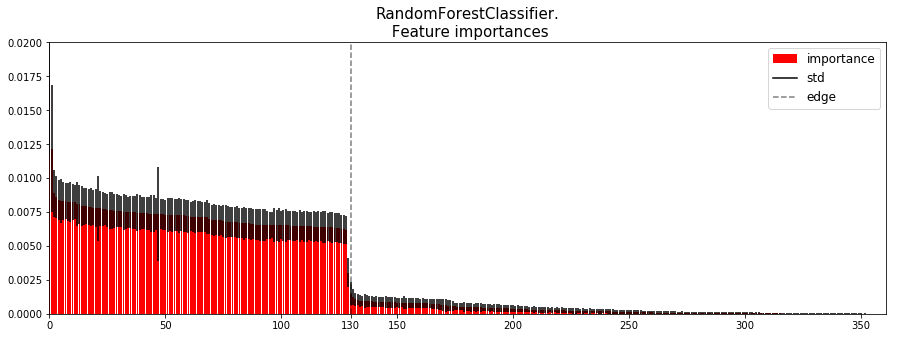

Feature reduction: 130 -> 66


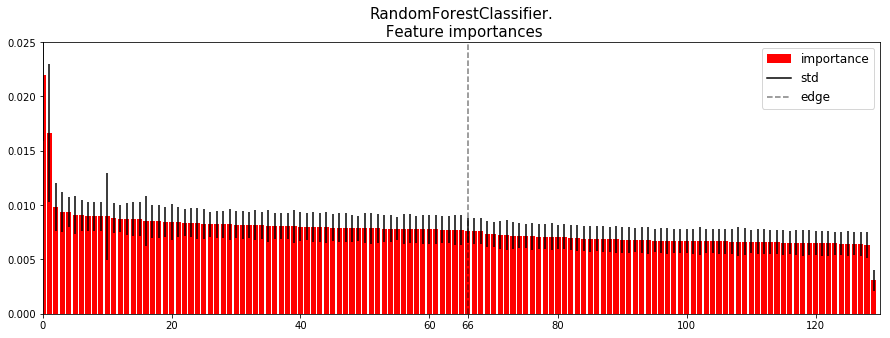

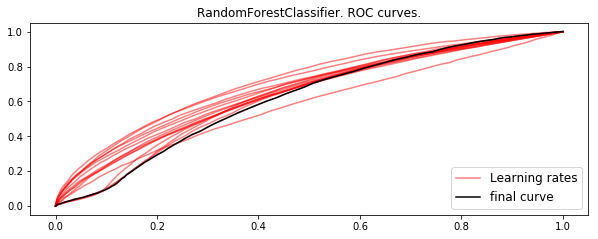

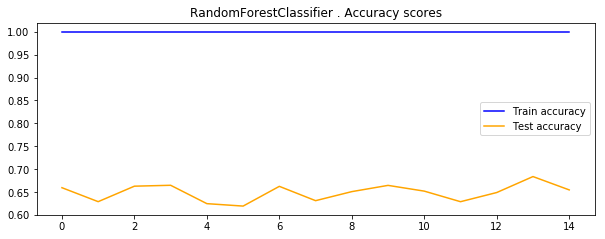

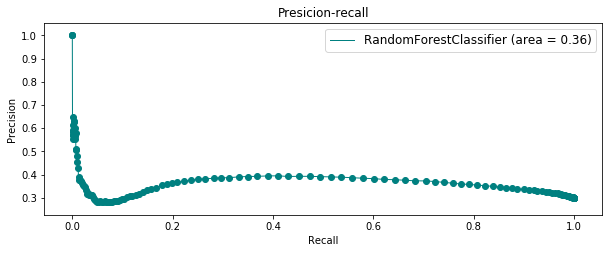

Average score: 0.64967003609


0.64967003609042639

In [3]:
rfc = Magnesium2("set_minresol_N_7.csv")
rfc.compute(n_splits = 15, test_size = 0.3)